In [1]:
#!/usr/bin/env python
'''File name: Centroids-and-Scatterplot.py
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 16.04.2018
    Date last modified: 16.04.2018

    ############################################################## 
    Purpos:

    Apply the optimal settings for the region of interest that was
    determined with:
    ~/papers/Extreme-WTs-US/programs/Extreme-WTs/SearchOptimum_ExtremeEvent-WeatherTyping.py

    1) Read the PRISM and ERA-Interim data
    2) Calculate the WT centroids
    3) Plot the Centroids
    3) Calculate Eucledian Distances for each day
    4) Plot ED vs. PR accumulation

'''

from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata


def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

# ###################################################
# Get the setup for the XWTing
DW_Regions=['San_Diego','LA','Central_Coast','Bay_Area','Northeast','Modoc','Siearas_East','Siearas_West']
SortXWTs = [[0,1],
           [0,1],
           [2,0,1],
           [1,0], #[2,3,1,0]
           [0,3,2,1], #[2,1,0],
           [1,0],
           [1,0,2],
           [2,1,0]]
Season='Annual' # ['AMJJAS', 'ONDJFM']
iReg=2 #int(sys.argv[1])
Region=DW_Regions[iReg]
from XWTs_apply_ERA5 import HUC2_XWTs_apply
rgdTime, iMonths, sPlotDir, sDataDir, sSubregionPR, rgsWTvars, VarsFullName,rgsWTfolders, rgrNrOfExtremes, \
    WT_Domains, DomDegreeAdd, Annual_Cycle, SpatialSmoothing, Metrics, Dimensions,FireObs,REANAL,\
    ClusterMeth, ClusterBreakup, RelAnnom, NormalizeData, MinDistDD, RemoveAnnualCycl= HUC2_XWTs_apply(Season,Region)
# rgrNrOfExtremes = 10

sSubregionPR=sSubregionPR+Region

# create nessesary directories
if not os.path.exists(sDataDir):
    os.makedirs(sDataDir)
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)
sRegion=Region.replace('/','-')

YYYY_stamp=str(rgdTime.year[0])+'-'+str(rgdTime.year[-1])
ss='-'
VarsJoint=ss.join(VarsFullName)
sMonths=ss.join([str(iMonths[ii]) for ii in range(len(iMonths))])
rgiSeasonWT=np.isin(rgdTime.month, iMonths)
rgiYears=np.unique(rgdTime.year)
rgdTime=rgdTime[rgiSeasonWT]
SPLIT=np.where(rgdTime.year < rgiYears[int(np.round(len(rgiYears)/2))])[0][-1]
rgdTimeMM = pd.date_range(datetime.datetime(rgdTime.year[0], rgdTime.month[0], rgdTime.day[0],0), end=datetime.datetime(rgdTime.year[-1], rgdTime.month[-1], rgdTime.day[-1],0), freq='m')

sPlotDir=sPlotDir+sRegion+'/'
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)

print(str(rgrNrOfExtremes)+' EXTREMES')
iNrOfExtremes=rgrNrOfExtremes   # we consider the N highest rainfall extremes

6 EXTREMES


In [2]:
# ###################################################
#       READ IN SHAPEFILE
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/GriddedData/MODIS_BA_GLOBAL_1_2016_01_gridded.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['rlat'][:])
rgrLonPR=np.squeeze(ncid.variables['rlon'][:])
ncid.close()
rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))
sf = shp.Reader(sSubregionPR)
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1
rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))

DomainSizes=['S','M','L','XXL']
DomDegreeAdd=[2,5,10,20]
DomDelta=DomDegreeAdd[DomainSizes.index(WT_Domains)]

Wlon=ctr[:,0].min()
Elon=ctr[:,0].max()
Nlat=ctr[:,1].max()
Slat=ctr[:,1].min()

DomainWT=np.array([[Elon+DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Slat-DomDelta]])
grWTregion=mplPath.Path(DomainWT)

# ###################################################
#         Read the FIRE observations
from Functions_Extreme_WTs import ExtremeDays
MinDistDD=7 # two extremes should be at least 7 days appart
if FireObs == 'MODIS':
    rgiSrPR=np.array(np.where(rgrSRactP == True))
    iLatMaxP=rgiSrPR[0,:].max()+1
    iLatMinP=rgiSrPR[0,:].min()
    iLonMaxP=rgiSrPR[1,:].max()+1
    iLonMinP=rgiSrPR[1,:].min()
    rgrPRdata=np.zeros((sum(rgiSeasonWT),iLatMaxP-iLatMinP,iLonMaxP-iLonMinP))

    for mo in range(len(rgdTimeMM)):
        rgiDD=np.where(((rgdTimeMM.year[mo] == rgdTime.year) & (rgdTime.month == rgdTimeMM.month[mo]) & np.isin(rgdTimeMM.month[mo], iMonths)))[0]
        ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/data_20020702/GriddedData/MODIS_BA_GLOBAL_1_'+str(rgdTimeMM.year[mo])+'_'+str("%02d" % rgdTimeMM.month[mo])+'_gridded.nc', mode='r')
        rgrPRdata[rgiDD,:,:]=np.squeeze(ncid.variables['BurnedArea'][:,iLatMinP:iLatMaxP,iLonMinP:iLonMaxP])
        ncid.close()
    rgrPRdata[rgrPRdata<0] = np.nan

    rgiSRgridcells=rgrSRactP[iLatMinP:iLatMaxP,iLonMinP:iLonMaxP].astype('int')
    rgrPRrecords=np.sum(rgrPRdata[:,(rgiSRgridcells==1)], axis=(1))
    rgiExtrTrain=ExtremeDays(rgrPRrecords,iNrOfExtremes,MinDistDD)
    rgiExtremeDays=rgdTime[rgiExtrTrain]
    
#     rgrPReval=np.nanmean(rgrPRdata[:,(rgiSRgridcells == 1)], axis=(1))
#     rgiExtremePR=ExtremeDays(rgrPReval,iNrOfExtremes,MinDistDD)
#     rgiExtremeDays=rgdTime[rgiExtremePR]
elif FireObs == 'Parks':
    SheanDataDir='/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Sean_Parks/SubRegion_DailyBurnedArea/'
    FILE=SheanDataDir+DW_Regions[iReg]+'.txt'
    rgrPRrecords=np.array(pd.read_csv(FILE, delim_whitespace=True, header = None))[:,0]

    rgiExtrTrain=ExtremeDays(rgrPRrecords,iNrOfExtremes,MinDistDD)
    rgiExtremeDays=rgdTime[rgiExtrTrain]

# ###################################################
# ###################################################
#             PERFORM CLUSTER ANALYSIS
sClusterSave=sDataDir+'Clusters'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season+'_'+\
    FireObs+'_'+REANAL+'_'+ClusterMeth+'_Breakup-'+str(ClusterBreakup)+'_RelAnnom-'+str(RelAnnom)+'_Norm-'+NormalizeData+\
    '_DDdist-'+str(MinDistDD)+'_RemAnnCyc-'+str(RemoveAnnualCycl)
if os.path.isfile(sClusterSave)  == 0:
    # ###################################################
    #         Read the ERA-Interim grid and data

#     from Functions_Extreme_WTs import ReadERAI
#     DailyVarsOrig, LonWT, LatWT=ReadERAI(grWTregion,        # shapefile with WTing region
#                                          rgdTime,           # time period for WTing
#                                          iMonths,           # list of months that should be considered
#                                          rgsWTfolders,      # directories containing WT files
#                                          rgsWTvars)         # netcdf variable names of WT variables
    
    from Functions_Extreme_WTs import ReadERA5
    DailyVarsOrig, LonWT, LatWT=ReadERA5(grWTregion,        # shapefile with WTing region
                                         rgdTime,           # time period for WTing
                                         iMonths,           # list of months that should be considered
                                         rgsWTfolders,      # directories containing WT files
                                         rgsWTvars)         # netcdf variable names of WT variables

    # run split sample thest and derive centroids of full dataset
    Samples=['SS1',"SS2","Full"]
    grClustersFin={}
    grEucledianDist={}
    grCorrelation={}
    grPSS={}
    grMRD={}
    grMRR={}
    grExluded={}
    grAPR={}
    for ss in [2]: #range(len(Samples)):
        print('    Split Sample '+Samples[ss])
        if ss == 0:
            DailyVarsTrain=DailyVarsOrig[:SPLIT,:]
            DailyVarsEval=DailyVarsOrig[-SPLIT:,:]
            Ptrain=rgrPRrecords[:SPLIT]
            Peval=rgrPRrecords[-SPLIT:]
            TimeTrain=rgdTime[:SPLIT]
            TimeEval=rgdTime[-SPLIT:]
        elif ss == 1:
            DailyVarsTrain=DailyVarsOrig[-SPLIT:,:]
            DailyVarsEval=DailyVarsOrig[:SPLIT,:]
            Ptrain=rgrPRrecords[-SPLIT:]
            Peval=rgrPRrecords[:SPLIT]
            TimeTrain=rgdTime[-SPLIT:]
            TimeEval=rgdTime[:SPLIT]
        elif ss == 2:
            DailyVarsTrain=DailyVarsOrig
            DailyVarsEval=DailyVarsOrig
            Ptrain=rgrPRrecords
            Peval=rgrPRrecords
            TimeTrain=rgdTime
            TimeEval=rgdTime
        XWT_output=XWT(DailyVarsTrain,
                        DailyVarsEval,
                        Ptrain,
                        Peval,
                        TimeTrain,
                        TimeEval,
                        iNrOfExtremes,
                        SpatialSmoothing,
                        ClusterMeth=ClusterMeth,
                        ClusterBreakup=ClusterBreakup,
                        RelAnnom=RelAnnom,
                        NormalizeData=NormalizeData,
                        MinDistDD=MinDistDD,
                        RemoveAnnualCycl=RemoveAnnualCycl)
        rgrClustersFin=XWT_output['grClustersFin']


        # ################################################
        # ######       EUCLEDIAN DISTANCES
        EucledianDist=XWT_output['EucledianDistAllWTs']
        Correlation =XWT_output['grCorrelatioAllWTs']
        rgrClustersFin=XWT_output['grClustersFin']

        from Functions_Extreme_WTs import Scatter_ED_PR
        MinDistance=np.min(EucledianDist, axis=1)
        ClosestWT=np.argmin(EucledianDist, axis=1)
        MaxCorr=np.max(Correlation, axis=1)
        Scatter_ED_PR(MinDistance,
                      ClosestWT,
                      Peval,
                      rgrNrOfExtremes,
                      PlotLoc=sPlotDir,
                      PlotName='Scatter_'+sRegion+'_NrExt-'+str(rgrNrOfExtremes)+'_Smooth-'+str(SpatialSmoothing)+'_AnnCy-'+Annual_Cycle+'_'+VarsJoint+'_'+sMonths+'_'+Samples[ss]+'.pdf')

        # Perkins Skill Score
        grPSS[Samples[ss]]=XWT_output['grPSS']
        # Mean relative difference
        grMRD[Samples[ss]]=XWT_output['grMRD']
        # Mean Rank Ratio
        grMRR[Samples[ss]]=XWT_output['grMRR']
        # % of days excluded
        grExluded[Samples[ss]]=np.abs(XWT_output['PEX']/100.-1)
        # % of days excluded
        grAPR[Samples[ss]]=np.abs(XWT_output['APR']-1)
        # save the data
        grClustersFin[Samples[ss]]=XWT_output['grClustersFin']
        grEucledianDist[Samples[ss]]=XWT_output['grEucledianDist']
        grCorrelation[Samples[ss]]=XWT_output['grCorrelatio']
    
    DATAcollection={'grClustersFin':grClustersFin, 
                    'grEucledianDist': grEucledianDist, 
                    'grCorrelatio':grCorrelation,
                    'grPSS':grPSS,
                    'grMRD':grMRD,
                    'grMRR':grMRR,
                    'grExluded':grExluded,
                    'grAPR':grAPR,
                    'LonWT':LonWT,
                    'LatWT':LatWT,
                    'iReg':iReg,
                    'VarsFullName':VarsFullName,
                    'rgrNrOfExtremes':rgrNrOfExtremes,
                    'WT_Domains':WT_Domains,
                    'SpatialSmoothing':SpatialSmoothing,
                    'MinDistance':MinDistance,
                    'Peval':Peval,
                    'rgdTime':rgdTime}

    with open(sClusterSave, 'wb') as handle:
        pickle.dump(DATAcollection, handle)

print('    Restore: '+sClusterSave)
with open(sClusterSave, 'rb') as handle:
    npzfile = pickle.load(handle)

grClustersFin=npzfile['grClustersFin']
grEucledianDist=npzfile['grEucledianDist']
grCorrelation=npzfile['grCorrelatio']
rgdTime=npzfile['rgdTime']

rgrClustersFin=grClustersFin['Full']
EucledianDist=grEucledianDist['Full']
Correlation=grCorrelation['Full']

# sort the clusters according to the number of days to ensure that the
# same pattern is at the same location for different event sample sizes
rgiClustSize=[sum(rgrClustersFin[1] == cc) for cc in range(rgrClustersFin[1].max()+1)]
rgiSorted=np.argsort(rgiClustSize)
rgiSorted=range(len(rgiSorted))

    Restore: /glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/AUC-APR/Clusters6_Central_Coast_2001-2019_RH2AVG-SLPAVG-WSPD10_Annual_MODIS_ERA5_hdbscan_Breakup-0_RelAnnom-1_Norm-D_DDdist-7_RemAnnCyc-1


In [3]:
# #############################################################################
# ######             PLOT PRECIPITATION IN WTs
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

# # start reading in the precipitation from PRISM for a larger region
# iRegionPlus=100 # grid cell added around shape rectangle
# ncid=Dataset('/glade/work/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2014.nc', mode='r') # open the netcdf file
# rgrLatPR=np.squeeze(ncid.variables['lat'][:])
# rgrLonPR=np.squeeze(ncid.variables['lon'][:])
# ncid.close()
# rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
# rgrSRact=np.array(grPRregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (rgrLatPR.shape[0], rgrLatPR.shape[1]))
# rgiSrPR=np.array(np.where(rgrSRact == True))
# iLatMax=np.min([rgiSrPR[0,:].max()+100, rgrLatPR.shape[0]-1])
# iLatMin=np.max([rgiSrPR[0,:].min()-100, 0])
# iLonMax=np.min([rgiSrPR[1,:].max()+100, rgrLatPR.shape[1]-1])
# iLonMin=np.max([rgiSrPR[1,:].min()-100, 0])
# rgrLatPR_SR=rgrLatPR[iLatMin:iLatMax,iLonMin:iLonMax]
# rgrLonPR_SR=rgrLonPR[iLatMin:iLatMax,iLonMin:iLonMax]
# rgrPRdata=np.zeros((rgrNrOfExtremes,iLatMax-iLatMin,iLonMax-iLonMin)); rgrPRdata[:]=np.nan
# jj=0
# for dd in range(len(rgiExtremeDays)):
#     rgdTimeYY = pd.date_range(datetime.datetime(rgiExtremeDays[dd].year, 01, 01,0), end=datetime.datetime(rgiExtremeDays[dd].year, 12, 31,23), freq='d')
#     rgiDD=np.where(((rgdTimeYY.year == rgiExtremeDays[dd].year) & (rgdTimeYY.month ==rgiExtremeDays[dd].month ) & (rgdTimeYY.day == rgiExtremeDays[dd].day)))[0]
#     ncid=Dataset('/glade/work/prein/observations/PRISM/data/PR/PRISM_daily_ppt_'+str(rgiExtremeDays[dd].year)+'.nc', mode='r')
#     try:
#         rgrPRdata[dd,:,:]=np.squeeze(ncid.variables['PR'][rgiDD[0],iLatMin:iLatMax,iLonMin:iLonMax])
#     except:
#         stop()
#     ncid.close()
#     jj=jj+len(rgiDD)
# rgrPRdata[rgrPRdata < 0]=np.nan

# # precipitation in WTs
# rgrPR_WTs=np.zeros((rgrClustersFin[1].max()+1,rgrPRdata.shape[1],rgrPRdata.shape[2])); rgrPR_WTs[:]=np.nan
# for cc in range(rgrClustersFin[1].max()+1):
#     rgiClAct=(rgrClustersFin[1] == (cc))
#     try:
#         rgrPR_WTs[cc,:]=np.nanmean(rgrPRdata[rgiClAct,:], axis=0)
#     except:
#         stop()

# plt.rcParams.update({'font.size': 18})
# rgsLableABC=list(string.ascii_lowercase)

# fig = plt.figure(figsize=(15,12))
# gs1 = gridspec.GridSpec(2,4)
# gs1.update(left=0.01, right=0.99,
#            bottom=0.18, top=0.85,
#            wspace=0.05, hspace=0.15)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLonPR_SR),np.max(rgrLonPR_SR)
# rllcrnrlat=rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
# urcrnrlat=urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
# llcrnrlon=llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
# urcrnrlon=urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
# for yy in range(3):
#     for xx in range(4):
#         # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
#         if yy*4+xx < rgrClustersFin[1].max()+1:
#             iSampleSize=np.sum(rgrClustersFin[1] == ([yy*4+xx]))
#             rAvPR=np.mean(rgrPRrecords[rgiExtremePR][rgrClustersFin[1] == (rgiSorted[yy*4+xx])])
#             ax = plt.subplot(gs1[yy,xx])
#             m = Basemap(projection='cea',\
#                             llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
#                             llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='i', fix_aspect=False)
#             plt.axis('off')
#             xi, yi = m(rgrLonPR_SR, rgrLatPR_SR)
#             #Load ColorMap
#             rgrColorTable=['#00eeef','#00a5f3','#0505ef','#00ff00','#03c502','#058c02','#fff707','#e6bd01','#ff8f08','#ff0000','#d90104','#b70500','#f107fe']
#             biasContDist=8
#             iContNr=len(rgrColorTable)+1
#             clevs=np.arange(0, iContNr*biasContDist,biasContDist)# ; clevs.astype('float')
#             clevs=np.append([0],clevs); clevs[1]=1
#             rgrColorTable=np.append(['#ffffff'],rgrColorTable)
#             rgrDataAct=rgrPR_WTs[rgiSorted[yy*4+xx], :,:]
#             cs = m.contourf(xi,yi,rgrDataAct,clevs,colors=rgrColorTable, extend='max')
#             # Lable the map
#             plt.title(rgsLableABC[yy*4+xx]+') WT'+str(yy*4+xx+1)+'\n'+str(iSampleSize)+' days, '+str(int(rAvPR))+' mm d$^{-1}$') #, fontsize=16)

#             # # plot the orography
#             # levels = np.array([200, 600,10000])
#             # xiO, yiO = m(rgrLonOro, rgrLatOro)
#             # CS = plt.contour(xiO, yiO, rgrOro, levels,
#             #          colors='k', linewidth=0.5)

#             # plot US States
#             sUSStates='/glade/u/home/prein/ShapeFiles/US-States/cb_2013_us_state_5m'
#             m.readshapefile(sUSStates, 'Temp_sf', drawbounds=True, linewidth=0.5, color='k')

#             # add shapefile of catchment
#             XX,YY=m(ctr[:,0], ctr[:,1])
#             m.plot(XX,YY, c='k', lw=2)

# # add colorbar
# CbarAx = axes([0.10, 0.07, 0.80, 0.02])
# cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=clevs)
# cb.ax.set_title('precipitation [mm d$^{-1}$]')


# # Save the plot
# # plt.show()
# sPlotFile=sPlotDir
# # sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_precipitation.pdf'
# sPlotName= 'BottomUp_'+str("%03d" % iNrOfExtremes)+'_Events'+'_'+str(rgrClustersFin[1].max()+1)+'WT_precipitation'+'_'+YYYY_stamp+'_'+VarsJoint+'_'+sMonths+'.pdf'
# if os.path.isdir(sPlotFile) != 1:
#     subprocess.call(["mkdir","-p",sPlotFile])
# print '        Plot map to: '+sPlotFile+sPlotName
# fig.savefig(sPlotFile+sPlotName)

In [4]:
# #############################################################################
# ######             PLOT THE CENTROIDS

from Functions_Extreme_WTs import add_subplot_axes

if (DW_Regions[iReg] == 'Modoc') | (DW_Regions[iReg] == 'Northeast') | (DW_Regions[iReg] == 'Siearas_East') | (DW_Regions[iReg] == 'Siearas_West'):
    rgsWTvarsA=['Z500','U500','V500','CAPE','MR850']
    rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA5/Z500/Z500_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/U500/U500_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/V500/V500_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/CAPE/CAPE_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/MR850/MR850']
else:
    rgsWTvarsA=['Z500','U850','V850','CAPE','MR850']
    rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA5/Z500/Z500_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/U850/U850_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/V850/V850_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/CAPE/CAPE_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/MR850/MR850']

DW_Regions=['San_Diego','LA','Central_Coast','Bay_Area','Northeast','Modoc','Siearas_East','Siearas_West']

# rgsWTvarsA=['Z500','U10AVG','V10AVG','CAPE','MR2AVG']
# rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA5/Z500/Z500_',\
#               '/glade/campaign/mmm/c3we/prein/ERA5/U10AVG/U10AVG_',\
#               '/glade/campaign/mmm/c3we/prein/ERA5/V10AVG/V10AVG_',\
#               '/glade/campaign/mmm/c3we/prein/ERA5/CAPE/CAPE_',\
#               '/glade/campaign/mmm/c3we/prein/ERA5/MR2AVG/MR2AVG_']
# start reading in the precipitation from PRISM for a larger region
iRegionPlus=70 # grid cell added around shape rectangle
ncid=Dataset('/glade/campaign/mmm/c3we/prein/ERA5/U850/U850_2006.nc', mode='r') # open the netcdf file
rgrLatWT1D=np.squeeze(ncid.variables['latitude'][:])
rgrLonWT1D=np.squeeze(ncid.variables['longitude'][:])
ncid.close()
rgrLonWT=np.asarray(([rgrLonWT1D,]*rgrLatWT1D.shape[0]))
rgrLonWT[rgrLonWT > 180]=rgrLonWT[rgrLonWT > 180]-360
rgrLatWT=np.asarray(([rgrLatWT1D,]*rgrLonWT1D.shape[0])).transpose()
rgrGridCells=[(rgrLonWT.ravel()[ii],rgrLatWT.ravel()[ii]) for ii in range(len(rgrLonWT.ravel()))]
rgrSRact=np.array(grWTregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (rgrLatWT.shape[0], rgrLatWT.shape[1]))
rgiSrWT=np.array(np.where(rgrSRact == True))
iLatMax=rgiSrWT[0,:].max()+iRegionPlus
iLatMin=rgiSrWT[0,:].min()-iRegionPlus
iLonMax=rgiSrWT[1,:].max()+iRegionPlus
iLonMin=rgiSrWT[1,:].min()-iRegionPlus
rgrLatWT_SR=rgrLatWT[iLatMin:iLatMax,iLonMin:iLonMax]
rgrLonWT_SR=rgrLonWT[iLatMin:iLatMax,iLonMin:iLonMax]
rgrWTdata=np.zeros((len(rgiExtremeDays),iLatMax-iLatMin,iLonMax-iLonMin,len(rgsWTvarsA))); rgrWTdata[:]=np.nan

for dd in range(len(rgiExtremeDays)):
    rgdTimeYY = pd.date_range(datetime.datetime(rgiExtremeDays[dd].year, 1, 1,0), end=datetime.datetime(rgiExtremeDays[dd].year, 12, 31,23), freq='d')
    rgiDD=np.where(((rgdTimeYY.year == rgiExtremeDays[dd].year) & (rgdTimeYY.month ==rgiExtremeDays[dd].month ) & (rgdTimeYY.day == rgiExtremeDays[dd].day)))[0]
    for va in range(len(rgsWTvarsA)):
        FILE = glob.glob(rgsWTfoldersA[va]+'*'+str(rgiExtremeDays[dd].year)+'.nc')[0]
        ncid=Dataset(FILE, mode='r')
        rgrWTdata[dd,:,:,va]=np.squeeze(ncid.variables[rgsWTvarsA[va]][rgiDD[0],iLatMin:iLatMax,iLonMin:iLonMax])
        ncid.close()
# average over the WTs
rgrWTcentroids=np.zeros((rgrClustersFin[1].max()+1,rgrWTdata.shape[1],rgrWTdata.shape[2],rgrWTdata.shape[3])); rgrWTcentroids[:]=np.nan
for cc in range(rgrClustersFin[1].max()+1):
    rgiClAct=(rgrClustersFin[1] == (cc))
    rgrWTcentroids[cc,:]=np.mean(rgrWTdata[rgiClAct,:,:,:], axis=0)


# Calculate the geometry of the plot dependent on how many panels there are
PanWidth=4 # cm
PanHeight=2.5 # cm
xdist=0.5
ydist=0.5
Panels=rgrClustersFin[1].max()+1
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

X_Fig=PanWidth*iColums+xdist*(iColums+1)
Y_Fig=PanHeight*iRows+(iRows+1)

In [5]:
rgrClustersFin[1]

array([0, 1, 2, 0, 1, 1])

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/WT-Centroids/Central_Coast/BottomUp_006_Events_3WT_Centroids_2001-2019_RH2AVG-SLPAVG-WSPD10_1-2-3-4-5-6-7-8-9-10-11-12.pdf


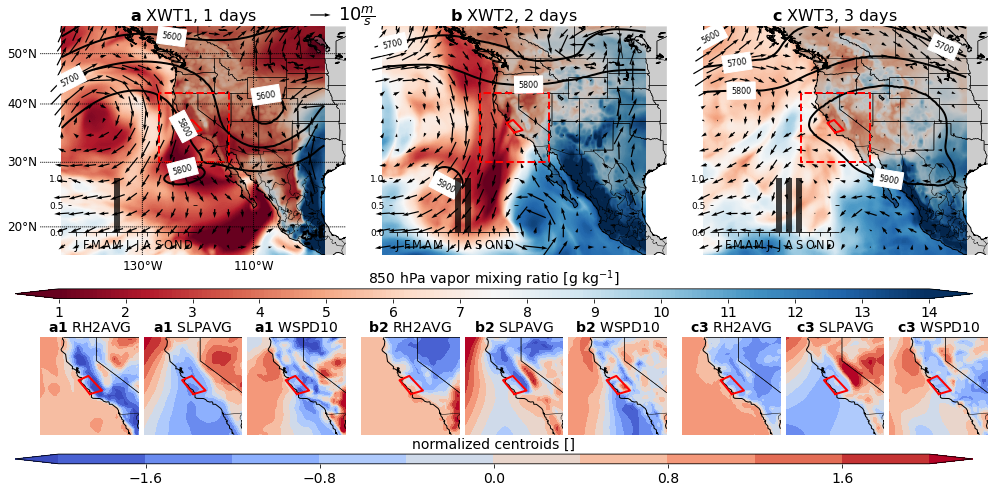

In [6]:
plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(X_Fig,Y_Fig*1.5))
gs1 = gridspec.GridSpec(iRows,iColums)
gs1.update(left=0.05, right=0.99,
           bottom=0.47, top=0.94,
           wspace=0.05, hspace=0.20)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
dLat=((52-25)/2.)*1.5
dLon=(130-75)/2.
rllcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
for wt in range(Panels):
    pa = SortXWTs[iReg][wt]
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=np.sum(rgrClustersFin[1] == pa)
    ax = plt.subplot(gs1[iYY[wt],iXX[wt]])
    try:
        m = Basemap(projection='cea',\
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
    except:
        stop()
    plt.axis('off')
    xi, yi = m(rgrLonWT_SR, rgrLatWT_SR)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot IVT
    biasContDist=10
    iContNr=len(rgrColorTable)+1
    clevs=np.linspace(1, 14,200)
    rgrDataAct=rgrWTcentroids[pa, :,:,rgsWTvarsA.index('MR850')]*1000.
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='RdBu', extend='both', alpha=1, zlevel=20)
    # plot wind field
    iLev=1; iDist=10
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],rgrWTcentroids[pa,::iDist,::iDist,1],
                   rgrWTcentroids[pa,::iDist,::iDist,2], units='width',zorder = 2, pivot='middle',width=0.004, scale=150)
    if wt == 0:
        qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
    # plot geopotential height
    iContNr=20
    clevs=np.arange(0,10000,100)
    CS=m.contour(xi[:,:],yi[:,:],rgrWTcentroids[pa,:,:,rgsWTvarsA.index('Z500')]/9.81,levels=clevs.astype('int'),
                 colors='k',linewidths=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]
    # plot cluster region
    iLatMax=rgrLatWT1D[rgiSrWT[0,:].max()]
    iLatMin=rgrLatWT1D[rgiSrWT[0,:].min()]
    iLonMax=rgrLonWT1D[rgiSrWT[1,:].max()]
    iLonMin=rgrLonWT1D[rgiSrWT[1,:].min()]
    lats = [iLatMin, iLatMax, iLatMax, iLatMin,iLatMin]
    lons = np.array([iLonMin, iLonMin, iLonMax, iLonMax, iLonMin])-360
    x, y = m(lons,lats)
    m.plot(x,y, lw=2, ls='--', c='r')

    # Lable the map
    plt.title(r"$\bf{" + str(rgsLableABC[wt]) + "}$"' XWT'+str(wt+1)+', '+str(iSampleSize)+' days', fontsize=16)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    
    if wt == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # Add Histogram in the lower left corner
    rect = [0.1,0.1,0.4,0.25]
    ax1 = add_subplot_axes(ax,rect)
    # plt.axis('off')
    rgiMonths=np.array([rgiExtremeDays[rgrClustersFin[1] == pa][nn].month for nn in range(len(rgiExtremeDays[rgrClustersFin[1] == pa]))])
    ax1.hist(rgiMonths,np.array(range(1,13,1))+0.5, facecolor='k', alpha=0.75,rwidth=0.6)#, normed=1
    ax1.set_xticks(np.array(range(1,20,1)))
    ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlim([0.5,12.5])
    # ax2.yaxis.set_ticks_position('left')
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax1.patch.set_alpha(0.0)


    # ==========================================================================================
    # ==========================================================================================
    # plot the actual centroids for each WT
    LonWT=npzfile['LonWT']
    LatWT=npzfile['LatWT']
    pos1 = np.array(ax.get_position())
    gs2 = gridspec.GridSpec(1,len(rgsWTvars))
    gs2.update(left=pos1[0][0], right=pos1[1][0],
           bottom=0.10, top=0.30,
           wspace=0.05, hspace=0.20)
    for va in range(len(rgsWTvars)):
        ax = plt.subplot(gs2[0,va])
        CentroidsAct=rgrClustersFin[0][pa]
        CentroidsAct=np.reshape(CentroidsAct,(LonWT.shape[0],LonWT.shape[1],len(rgsWTvars)))
        m = Basemap(projection='cea',\
                    llcrnrlat= np.min(LatWT) ,urcrnrlat=np.max(LatWT),\
                    llcrnrlon=np.min(LonWT),urcrnrlon=np.max(LonWT),resolution='l', fix_aspect=False)
        xi, yi = m(LonWT, LatWT)
        cs1= plt.contourf(xi, yi, CentroidsAct[:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
        plt.axis('off')
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        m.plot(XX,YY, c='r', lw=2)
        m.drawcoastlines(color='k')
        m.drawcountries(color='k')
        m.drawstates(color='k')
        plt.title(r"$\bf{" + str(rgsLableABC[wt]) +  str(int(wt+1))+ "}$"+' '+VarsFullName[va], fontsize=14)

# add colorbar for IVT
CbarAx = axes([0.025, 0.38, 0.95, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=np.arange(1,21,1))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('850 hPa vapor mixing ratio [g kg$^{-1}$]', fontsize=14)

# add colorbar for centroids
CbarAx = axes([0.025, 0.04, 0.95, 0.02])
cb = colorbar(cs1, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=np.arange(300,1600,200))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('normalized centroids []', fontsize=14)

# Save the plot
# plt.show()
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'BottomUp_'+str("%03d" % iNrOfExtremes)+'_Events_'+str(rgrClustersFin[1].max()+1)+'WT_Centroids_'+YYYY_stamp+'_'+VarsJoint+'_'+sMonths+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)


### Plot the individual XWT days

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/WT-Centroids/Central_Coast/XWT-Days/01_2017-07-10_BottomUp_006_Events_3WT_Centroids_2001-2019_RH2AVG-SLPAVG-WSPD10_1-2-3-4-5-6-7-8-9-10-11-12.png
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/WT-Centroids/Central_Coast/XWT-Days/02_2009-08-28_BottomUp_006_Events_3WT_Centroids_2001-2019_RH2AVG-SLPAVG-WSPD10_1-2-3-4-5-6-7-8-9-10-11-12.png
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/WT-Centroids/Central_Coast/XWT-Days/03_2017-05-19_BottomUp_006_Events_3WT_Centroids_2001-2019_RH2AVG-SLPAVG-WSPD10_1-2-3-4-5-6-7-8-9-10-11-12.png
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/WT-Centroids/Central_Coast/XWT-Days/01_2005-08-24_BottomUp_006_Events_3WT_Centroids_2001-2019_RH2AVG-SLPAVG-WSPD10_1-2-3-4-5-6-7-8-9-10-11-12.png
        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/WT-Centroids/Cen

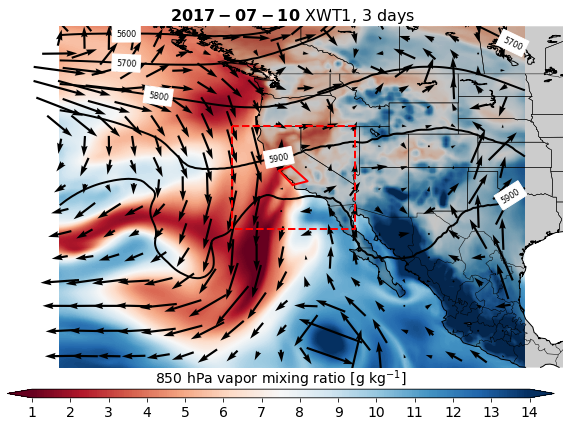

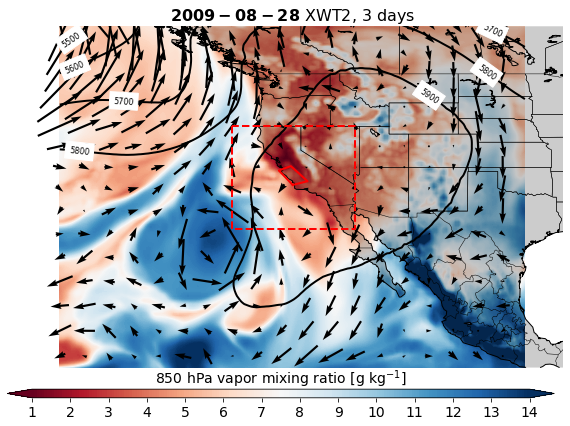

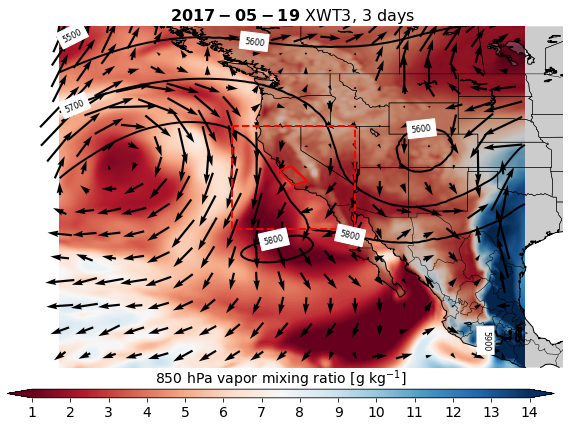

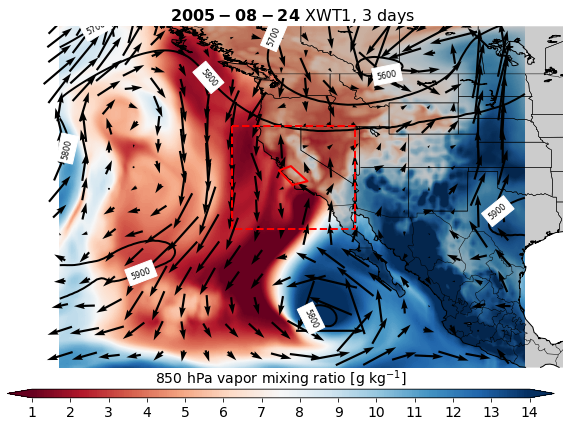

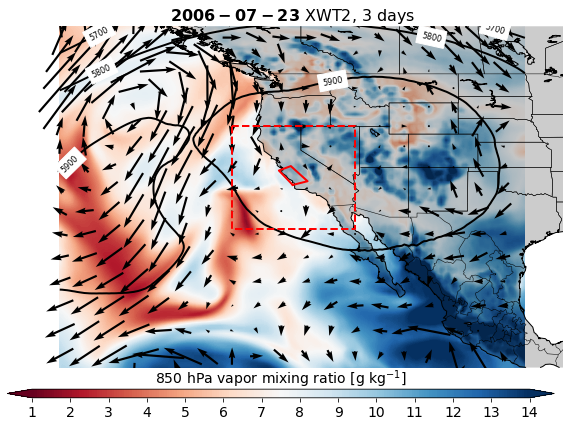

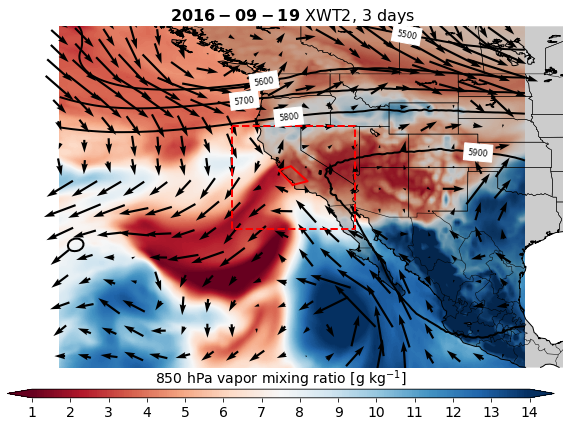

In [7]:
X_Fig=PanWidth*iColums+xdist*(1)
Y_Fig=PanHeight*iRows+(1)
for dd in range(rgrWTdata.shape[0]):
    Date = rgiExtremeDays[dd]
    iXWT = rgrClustersFin[1][dd]
    
    plt.rcParams.update({'font.size': 18})
    rgsLableABC=list(string.ascii_lowercase)
    fig = plt.figure(figsize=(8,6))
    gs1 = gridspec.GridSpec(1,1)
    gs1.update(left=0.05, right=0.99,
               bottom=0.15, top=0.94,
               wspace=0.05, hspace=0.20)
    # rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
    dLat=((52-25)/2.)*1.5
    dLon=(130-75)/2.
    rllcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
    urcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
    llcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
    urcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01

    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=np.sum(rgrClustersFin[1] == pa)
    ax = plt.subplot(gs1[0,0])
    try:
        m = Basemap(projection='cea',\
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
    except:
        stop()
    plt.axis('off')
    xi, yi = m(rgrLonWT_SR, rgrLatWT_SR)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot IVT
    biasContDist=10
    iContNr=len(rgrColorTable)+1
    clevs=np.linspace(1, 14,200)
    rgrDataAct=rgrWTdata[dd, :,:,rgsWTvarsA.index('MR850')]*1000.
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='RdBu', extend='both', alpha=1, zlevel=20)
    # plot wind field
    iLev=1; iDist=10
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],rgrWTdata[dd,::iDist,::iDist,1],
                   rgrWTdata[dd,::iDist,::iDist,2], units='width',zorder = 2, pivot='middle',width=0.004, scale=150)
    if wt == 0:
        qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
    # plot geopotential height
    iContNr=20
    clevs=np.arange(0,10000,100)
    CS=m.contour(xi[:,:],yi[:,:],rgrWTdata[dd,:,:,rgsWTvarsA.index('Z500')]/9.81,levels=clevs.astype('int'),
                 colors='k',linewidths=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]
    # plot cluster region
    iLatMax=rgrLatWT1D[rgiSrWT[0,:].max()]
    iLatMin=rgrLatWT1D[rgiSrWT[0,:].min()]
    iLonMax=rgrLonWT1D[rgiSrWT[1,:].max()]
    iLonMin=rgrLonWT1D[rgiSrWT[1,:].min()]
    lats = [iLatMin, iLatMax, iLatMax, iLatMin,iLatMin]
    lons = np.array([iLonMin, iLonMin, iLonMax, iLonMax, iLonMin])-360
    x, y = m(lons,lats)
    m.plot(x,y, lw=2, ls='--', c='r')

    # Lable the map
    plt.title(r"$\bf{" + str(Date)[:10] + "}$"' XWT'+str(iXWT+1)+', '+str(iSampleSize)+' days', fontsize=16)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)

    if wt == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # add colorbar for IVT
    CbarAx = axes([0.025, 0.08, 0.95, 0.02])
    cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=np.arange(1,21,1))
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_title('850 hPa vapor mixing ratio [g kg$^{-1}$]', fontsize=14)

    # Save the plot
    # plt.show()
    sPlotFile=sPlotDir+'XWT-Days/'
    # sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
    sPlotName= str(iXWT+1).zfill(2)+'_'+str(Date)[:10]+'_BottomUp_'+str("%03d" % iNrOfExtremes)+'_Events_'+str(rgrClustersFin[1].max()+1)+'WT_Centroids_'+YYYY_stamp+'_'+VarsJoint+'_'+sMonths+'.png'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print('        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName)

### Read in the fire dataset

In [8]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/GriddedData/MODIS_BA_GLOBAL_1_2016_01_gridded.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['rlat'][:])
rgrLonPR=np.squeeze(ncid.variables['rlon'][:])
ncid.close()
rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))
sf = shp.Reader(sSubregionPR)
from Functions_Extreme_WTs import read_shapefile
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1

rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))
rgiSrPR=np.array(np.where(rgrSRactP == True))
iLatMaxP=rgiSrPR[0,:].max()+1
iLatMinP=rgiSrPR[0,:].min()
iLonMaxP=rgiSrPR[1,:].max()+1
iLonMinP=rgiSrPR[1,:].min()
rgrPRdata=np.zeros((sum(rgiSeasonWT),iLatMaxP-iLatMinP,iLonMaxP-iLonMinP))

for mo in range(len(rgdTimeMM)):
    rgiDD=np.where(((rgdTimeMM.year[mo] == rgdTime.year) & (rgdTime.month == rgdTimeMM.month[mo]) & np.isin(rgdTimeMM.month[mo], iMonths)))[0]
    if len(rgiDD) != 0:
        ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/GriddedData/MODIS_BA_GLOBAL_1_'+str(rgdTimeMM.year[mo])+'_'+str("%02d" % rgdTimeMM.month[mo])+'_gridded.nc', mode='r')
        rgrPRdata[rgiDD,:,:]=np.squeeze(ncid.variables['BurnedArea'][:,iLatMinP:iLatMaxP,iLonMinP:iLonMaxP])
        ncid.close()
rgrPRdata[rgrPRdata<0] = np.nan


FileNotFoundError: [Errno 2] No such file or directory: b'/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/GriddedData/MODIS_BA_GLOBAL_1_2016_06_gridded.nc'

In [ ]:
WTcolors=['#1f78b4','#33a02c','#e31a1c','#ff7f00','#a6cee3','#b2df8a','#fb9a99','#fdbf6f','#cab2d6','#6a3d9a','#ffff99','#b15928','#1f78b4','#33a02c','#e31a1c','#ff7f00','#a6cee3','#b2df8a','#fb9a99','#fdbf6f','#cab2d6','#6a3d9a','#ffff99','#b15928']
fig = plt.figure(figsize=(12,5))
sta=0
sto=len(rgdTime)-1
# plt.plot(rgdTime[sta:sto],np.sum(rgrPRdata, axis=(1,2))[sta:sto])
# plt.plot(rgdTime[sta:sto],rgrPRrecords[sta:sto])
plt.plot(rgdTime,rgrPRrecords)
plt.xlabel('time [days]')
plt.ylabel('burned area [km$^2$ day$^{-1}$]')
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
#plot extreme events
for dd in range(len(rgiExtremeDays)):
    iXWT = rgrClustersFin[1][dd]
    iDD = np.where(rgiExtremeDays[dd] == rgdTime)[0][0]
    plt.plot(rgdTime[iDD], rgrPRrecords[iDD], marker = 'o', color=WTcolors[iXWT], label='cluster '+str(iXWT))
    
plt.legend()
    

In [ ]:
sClusterSave